In [ ]:
# Import necessary libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.stats import norm
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
import mplcyberpunk
from scipy.stats import norm


In [ ]:
# Library to style the plots
!pip install mplcyberpunk

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Read in 2 data files and view first few rows

file_path = '/content/drive/My Drive/altREU Data - Austin Bond Data.csv'
df = pd.read_csv(file_path)
df.head()

file_path = '/content/drive/My Drive/portland_data.csv'
df_portland = pd.read_csv(file_path)
df_portland.head()

,CUSIP*,Principal Amount at Issuance ($),Security Description *,Coupon,Maturity Date,Initial Offering (%),Unnamed: 6,Unnamed: 7,Current LT Rating,Unnamed: 9,Unnamed: 10,Unnamed: 11
0,NaN,NaN,NaN,NaN,NaN,Price/Yield,Price,Yield,Fitch,KBRA,Moody's,S&P
1,NaN,"7,515,000",TAXABLE-AFFORDABLE HSG PROJ,1.20,06/15/2026,-,100,1.2,-,-,NaN,-
2,NaN,"7,605,000",TAXABLE-AFFORDABLE HSG PROJ,1.30,06/15/2027,-,100,1.3,-,-,NaN,-
3,NaN,"7,705,000",TAXABLE-AFFORDABLE HSG PROJ,1.51,06/15/2028,-,100,1.51,-,-,NaN,-
4,NaN,"7,820,000",TAXABLE-AFFORDABLE HSG PROJ,1.61,06/15/2029,-,100,1.61,-,-,NaN,-


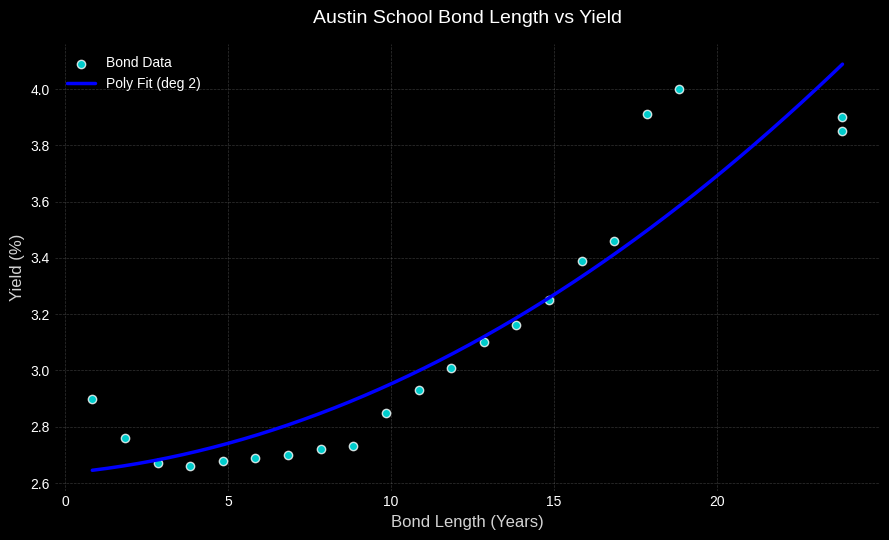

In [57]:
#Polynomial Regression as a Benchmark for comparison (Austin School Bond Data)

plt.style.use('dark_background')

# Data Preprocessing
df['Maturity Date'] = pd.to_datetime(df['Maturity Date'], errors='coerce')
today = pd.Timestamp(datetime.today().date())
df['Bond Length (Years)'] = (df['Maturity Date'] - today).dt.days / 365
df['Yield'] = pd.to_numeric(df['Unnamed: 7'], errors='coerce')
df = df.dropna(subset=['Bond Length (Years)', 'Yield'])
x = df['Bond Length (Years)']
y = df['Yield']

# Polynomial regression (degree 2)
coeffs = np.polyfit(x, y, deg=2)
poly = np.poly1d(coeffs)
x_curve = np.linspace(x.min(), x.max(), 200)
y_curve = poly(x_curve)

# Plot
plt.figure(figsize=(9, 5.5))
plt.scatter(x, y, color='cyan', edgecolors='white', label='Bond Data', alpha=0.8)
plt.plot(x_curve, y_curve, color='blue', linewidth=2.5, label='Poly Fit (deg 2)')

plt.title('Austin School Bond Length vs Yield', fontsize=14, color='white', pad=15)
plt.xlabel('Bond Length (Years)', fontsize=12, color='lightgray')
plt.ylabel('Yield (%)', fontsize=12, color='lightgray')
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()

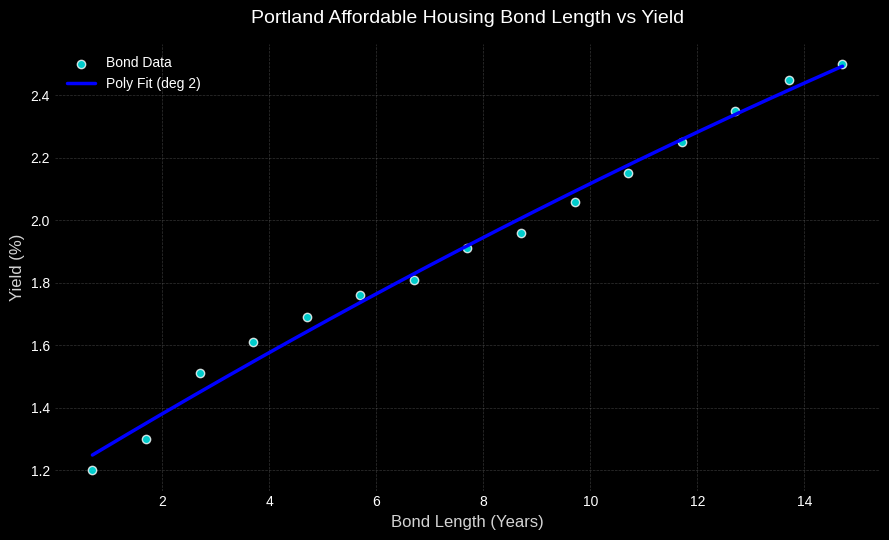

In [ ]:
#Polynomial Regression as a Benchmark for comparison (Portland Affordable Housing Bond Data)

plt.style.use('dark_background')

# Data preprocessing
df_portland['Maturity Date'] = pd.to_datetime(df_portland['Maturity Date'], errors='coerce')
today = pd.Timestamp(datetime.today().date())
df_portland['Bond Length (Years)'] = (df_portland['Maturity Date'] - today).dt.days / 365
df_portland['Yield'] = pd.to_numeric(df_portland['Unnamed: 7'], errors='coerce')
df_portland = df_portland.dropna(subset=['Bond Length (Years)', 'Yield'])
x = df_portland['Bond Length (Years)']
y = df_portland['Yield']

# Polynomial regression (degree 2)
coeffs = np.polyfit(x, y, deg=2)
poly = np.poly1d(coeffs)
x_curve = np.linspace(x.min(), x.max(), 200)
y_curve = poly(x_curve)

# Plot
plt.figure(figsize=(9, 5.5))
plt.scatter(x, y, color='cyan', edgecolors='white', label='Bond Data', alpha=0.8)
plt.plot(x_curve, y_curve, color='blue', linewidth=2.5, label='Poly Fit (deg 2)')

plt.title('Portland Affordable Housing Bond Length vs Yield', fontsize=14, color='white', pad=15)
plt.xlabel('Bond Length (Years)', fontsize=12, color='lightgray')
plt.ylabel('Yield (%)', fontsize=12, color='lightgray')
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()

/usr/local/lib/python3.12/dist-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Learned kernel: 1.46**2 * RBF(length_scale=10)
NLPD: -1.1327


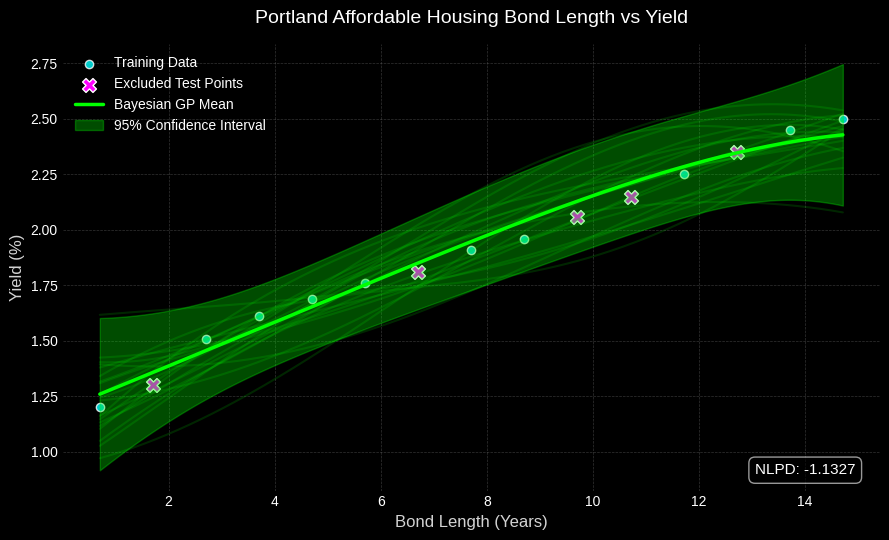

In [ ]:
# Make Bayesian Gaussian Process Regression Model for Portland Bond Data

plt.style.use('dark_background')

# Data Preprocessing

df_portland['Maturity Date'] = pd.to_datetime(df_portland['Maturity Date'], errors='coerce')
today = pd.Timestamp(datetime.today().date())
df_portland['Bond Length (Years)'] = (df_portland['Maturity Date'] - today).dt.days / 365
df_portland['Yield'] = pd.to_numeric(df_portland['Unnamed: 7'], errors='coerce')
df_portland = df_portland.dropna(subset=['Bond Length (Years)', 'Yield'])

# Exclude first and last index to avoid extrapolation in test and randomly choose 5

np.random.seed(42)
df_portland = df_portland.sort_values(by='Bond Length (Years)').reset_index(drop=True)
eligible_indices = df_portland.index[1:-1]
exclude_indices = np.random.choice(eligible_indices, size=5, replace=False)

# Train/test split
df_train = df_portland.drop(index=exclude_indices)
df_test = df_portland.loc[exclude_indices]

x_train = df_train['Bond Length (Years)'].values.reshape(-1, 1)
y_train = df_train['Yield'].values

x_test = df_test['Bond Length (Years)'].values.reshape(-1, 1)
y_test = df_test['Yield'].values

# Define kernel and Gaussian Process
kernel = C(1.0, (1e-3, 1e3)) * RBF(length_scale=0.5, length_scale_bounds=(1e-3, 10))
gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=15, alpha=0.05)

# Fit GP on training data
gpr.fit(x_train, y_train)
print("Learned kernel:", gpr.kernel_)

# Predict on dense grid
x_pred = np.linspace(x_train.min(), x_train.max(), 200).reshape(-1, 1)
y_pred, sigma = gpr.predict(x_pred, return_std=True)

# Sample from posterior
n_samples = 20
samples = gpr.sample_y(x_pred, n_samples=n_samples, random_state=42)

# Predict test points for NLPD
y_pred_test, sigma_test = gpr.predict(x_test, return_std=True)

# Calculate NLPD
nlpd = -np.mean(norm.logpdf(y_test, loc=y_pred_test, scale=sigma_test))
print(f"NLPD: {nlpd:.4f}")

# Plot results
plt.figure(figsize=(9, 5.5))
plt.scatter(x_train, y_train, color='cyan', edgecolors='white', label='Training Data', alpha=0.8)
plt.scatter(x_test, y_test, color='magenta', edgecolors='white', label='Excluded Test Points', s=100, marker='X')

for i in range(n_samples):
    plt.plot(x_pred, samples[:, i], color='lime', alpha=0.15)

plt.plot(x_pred, y_pred, color='lime', linewidth=2.5, label='Bayesian GP Mean')
plt.fill_between(
    x_pred.flatten(),
    y_pred - 2*sigma,
    y_pred + 2*sigma,
    color='lime',
    alpha=0.3,
    label='95% Confidence Interval'
)

plt.title('Portland Affordable Housing Bond Length vs Yield', fontsize=14, color='white', pad=15)
plt.xlabel('Bond Length (Years)', fontsize=12, color='lightgray')
plt.ylabel('Yield (%)', fontsize=12, color='lightgray')
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.4)
plt.legend()

# Show NLPD on the plot
plt.text(
    0.97, 0.03,
    f"NLPD: {nlpd:.4f}",
    fontsize=11,
    color='white',
    transform=plt.gca().transAxes,
    ha='right',
    va='bottom',
    bbox=dict(facecolor='black', alpha=0.6, boxstyle='round,pad=0.4')
)

plt.tight_layout()
plt.show()


/usr/local/lib/python3.12/dist-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Learned kernel: 2.24**2 * RBF(length_scale=10)
NLPD: -0.4355


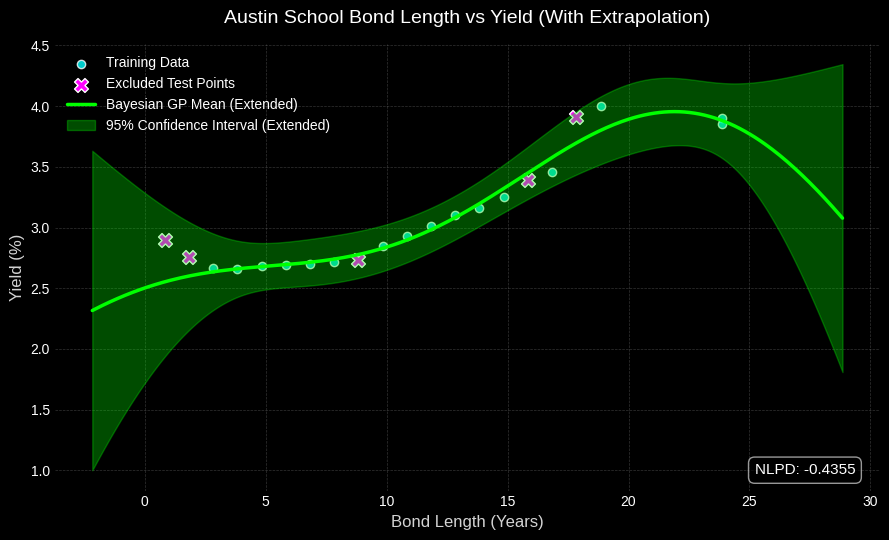

In [ ]:

# Make Bayesian Gaussian Process Regression Model for Austin Bond Data
# ** With Extrapolation in Test ** with extended prediction range

plt.style.use('dark_background')

# Data Preprocessing
df['Maturity Date'] = pd.to_datetime(df['Maturity Date'], errors='coerce')
today = pd.Timestamp(datetime.today().date())
df['Bond Length (Years)'] = (df['Maturity Date'] - today).dt.days / 365
df['Yield'] = pd.to_numeric(df['Unnamed: 7'], errors='coerce')
df = df.dropna(subset=['Bond Length (Years)', 'Yield'])

# Randomly select 5 indices to exclude for testing
np.random.seed(42)
exclude_indices = np.random.choice(df.index, size=5, replace=False)

# train/test split
df_train = df.drop(index=exclude_indices)
df_test = df.loc[exclude_indices]

x_train = df_train['Bond Length (Years)'].values.reshape(-1, 1)
y_train = df_train['Yield'].values

x_test = df_test['Bond Length (Years)'].values.reshape(-1, 1)
y_test = df_test['Yield'].values

# Kernel with RBF for flexibility
kernel = C(1.0, (1e-3, 1e3)) * RBF(length_scale=0.5, length_scale_bounds=(1e-3, 10))
gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=15, alpha=0.05)

# Fit model on training data
gpr.fit(x_train, y_train)
print("Learned kernel:", gpr.kernel_)

# Extended prediction range (5 years beyond data on both sides)
x_min_ext = x_train.min() - 5
x_max_ext = x_train.max() + 5
x_pred_ext = np.linspace(x_min_ext, x_max_ext, 300).reshape(-1, 1)

y_pred_ext, sigma_ext = gpr.predict(x_pred_ext, return_std=True)

plt.figure(figsize=(9, 5.5))

# Plot training data and excluded points
plt.scatter(x_train, y_train, color='cyan', edgecolors='white', label='Training Data', alpha=0.8)
plt.scatter(x_test, y_test, color='magenta', edgecolors='white', label='Excluded Test Points', s=100, marker='X')

# Plot GP mean prediction (extended)
plt.plot(x_pred_ext, y_pred_ext, color='lime', linewidth=2.5, label='Bayesian GP Mean (Extended)')

# Plot 95% confidence interval (extended)
plt.fill_between(
    x_pred_ext.flatten(),
    y_pred_ext - 2*sigma_ext,
    y_pred_ext + 2*sigma_ext,
    color='lime',
    alpha=0.3,
    label='95% Confidence Interval (Extended)'
)

# Predict mean and std for test points
y_pred_test, sigma_test = gpr.predict(x_test, return_std=True)

# Compute NLPD
nlpd = -np.mean(norm.logpdf(y_test, loc=y_pred_test, scale=sigma_test))
print(f"NLPD: {nlpd:.4f}")

# Show NLPD
plt.text(
    0.97, 0.03,
    f"NLPD: {nlpd:.4f}",
    fontsize=11,
    color='white',
    transform=plt.gca().transAxes,
    ha='right',
    va='bottom',
    bbox=dict(facecolor='black', alpha=0.6, boxstyle='round,pad=0.4')
)

plt.title('Austin School Bond Length vs Yield (With Extrapolation)', fontsize=14, color='white', pad=15)
plt.xlabel('Bond Length (Years)', fontsize=12, color='lightgray')
plt.ylabel('Yield (%)', fontsize=12, color='lightgray')
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()



<Figure size 1000x500 with 0 Axes>

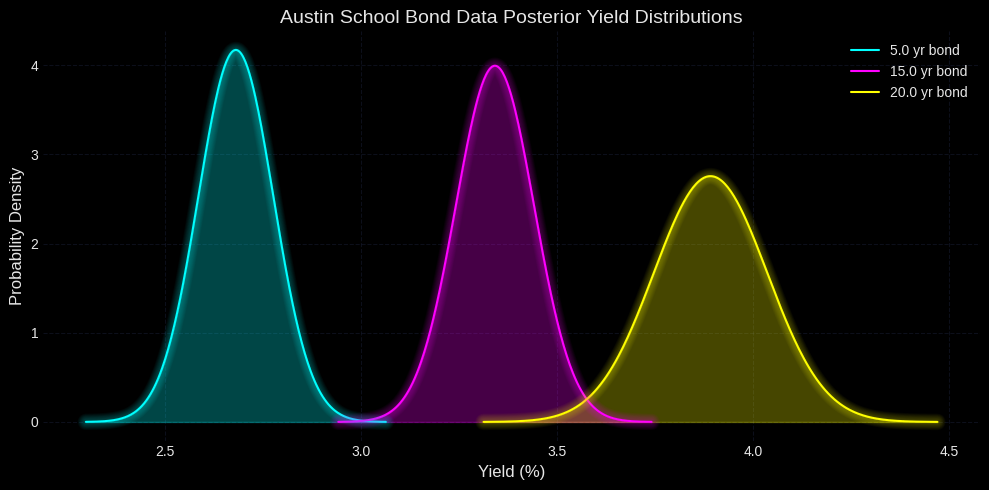

In [ ]:

# Select 3 bonds from above Austin school bond data lengths to inspect uncertainty for using posterior distributions

x_points = np.array([[5], [15], [20]])  # bond lengths in years
means, stds = gpr.predict(x_points, return_std=True)

# Styling
plt.style.use("cyberpunk")
plt.figure(figsize=(10, 5))
fig, ax = plt.subplots(figsize=(10,5))
fig.patch.set_facecolor('black')
ax.set_facecolor('black')
colors = ['cyan', 'magenta', 'yellow']

for i, (mu, std) in enumerate(zip(means, stds)):
    x_vals = np.linspace(mu - 4*std, mu + 4*std, 300)
    y_vals = norm.pdf(x_vals, mu, std)

    # Plot line
    plt.plot(x_vals, y_vals, color=colors[i], label=f'{x_points[i][0]:.1f} yr bond')

    plt.fill_between(x_vals, y_vals, color=colors[i], alpha=0.2)

plt.title("Austin School Bond Data Posterior Yield Distributions", fontsize=14)
plt.xlabel("Yield (%)", fontsize=12)
plt.ylabel("Probability Density", fontsize=12)
plt.legend()
plt.grid(True, linestyle="--", alpha=0.3)
plt.tight_layout()

mplcyberpunk.add_glow_effects()
plt.show()

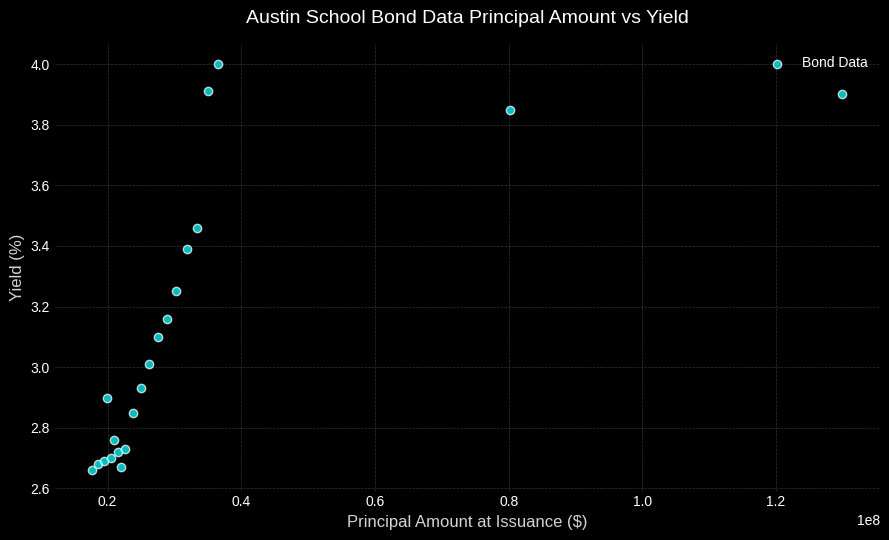

In [ ]:
# Extra Data Analysis - looking at relationship between Principal Amount and Yield for Austin school bond data

# Data preprocessing
df['Principal Amount'] = pd.to_numeric(df['Principal Amount at Issuance ($)'].str.replace(',', ''), errors='coerce')
df['Yield'] = pd.to_numeric(df['Unnamed: 7'], errors='coerce')
df_clean = df.dropna(subset=['Principal Amount', 'Yield'])

plt.style.use('dark_background')

# Scatterplot
plt.figure(figsize=(9, 5.5))
plt.scatter(
    df_clean['Principal Amount'],
    df_clean['Yield'],
    color='cyan',
    edgecolors='white',
    alpha=0.75,
    label='Bond Data'
)

plt.title('Austin School Bond Data Principal Amount vs Yield', fontsize=14, color='white', pad=15)
plt.xlabel('Principal Amount at Issuance ($)', fontsize=12, color='lightgray')
plt.ylabel('Yield (%)', fontsize=12, color='lightgray')
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()

Modular Workflow for Scalability

In [ ]:
def preprocess_bond_data(df_raw, yield_col='Unnamed: 7'):
    # Parse dates
    df = df_raw.copy()
    df['Maturity Date'] = pd.to_datetime(df['Maturity Date'], errors='coerce')

    # Compute bond length
    today = pd.Timestamp(datetime.today().date())
    df['Bond Length (Years)'] = (df['Maturity Date'] - today).dt.days / 365

    # Clean yield data
    df['Yield'] = pd.to_numeric(df[yield_col], errors='coerce')

    # Drop missing rows
    df = df.dropna(subset=['Bond Length (Years)', 'Yield'])

    # Sort by bond length to avoid min/max bias in test selection
    df = df.sort_values(by='Bond Length (Years)').reset_index(drop=True)

    return df

#Load and process data
#First two files are the ones used earlier in the exploratory analysis

file_path_portland_affordable_housing = '/content/drive/My Drive/portland_data.csv'
df_portland_raw = pd.read_csv(file_path_portland_affordable_housing)
df_portland = preprocess_bond_data(df_portland_raw)

file_path_austin_school_buildings = '/content/drive/My Drive/altREU Data - Austin Bond Data.csv'
df_austin_raw = pd.read_csv(file_path_austin_school_buildings)
df_austin = preprocess_bond_data(df_austin_raw)

file_path_portland_veteran_memorial = '/content/drive/My Drive/portland_veteran_memorial.csv'
df_portland_veteran_raw = pd.read_csv(file_path_portland_veteran_memorial)
df_portland_veteran = preprocess_bond_data(df_portland_veteran_raw)

file_path_katy = '/content/drive/My Drive/katy_school_bonds.csv'
df_katy = pd.read_csv(file_path_katy)
df_katy = preprocess_bond_data(df_katy)


/usr/local/lib/python3.12/dist-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Learned kernel: 2.28**2 * RBF(length_scale=10)


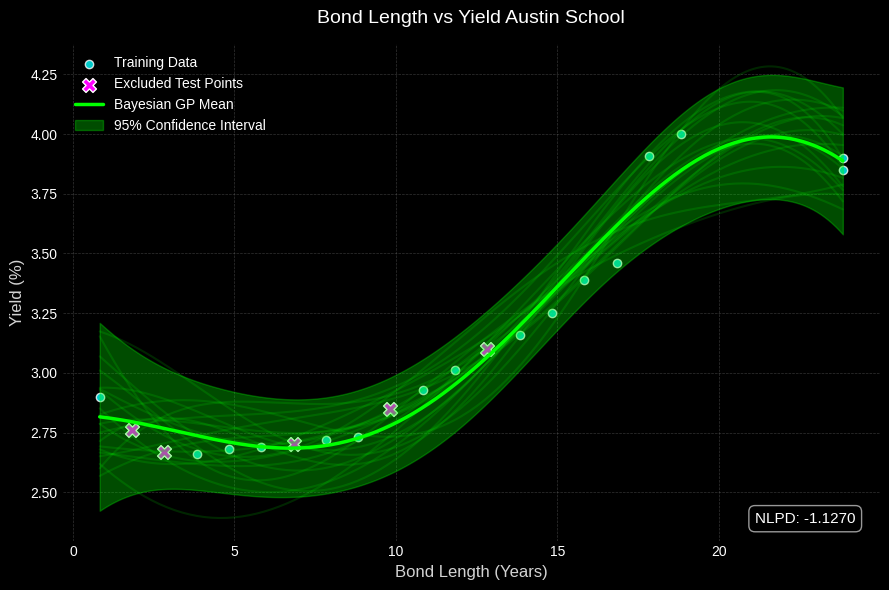

/usr/local/lib/python3.12/dist-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Learned kernel: 1.46**2 * RBF(length_scale=10)


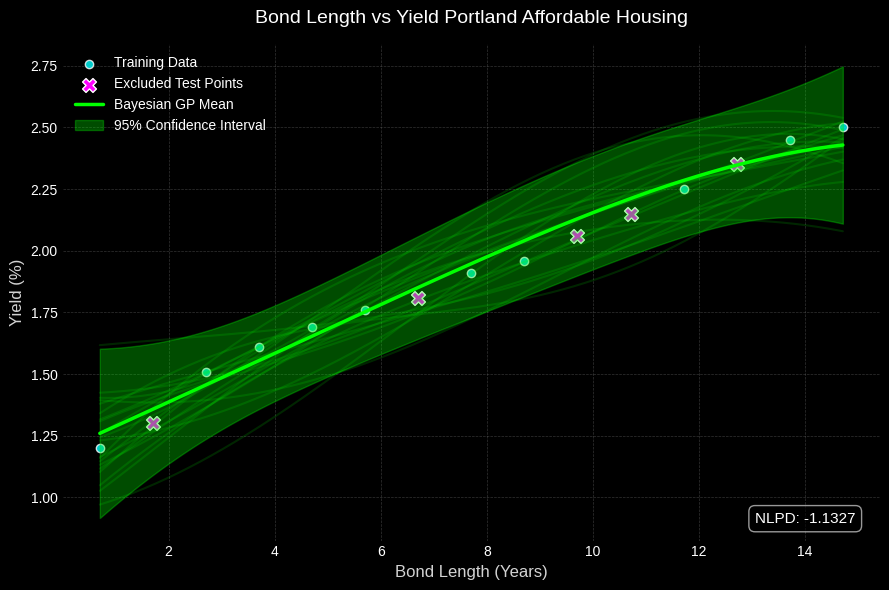

/usr/local/lib/python3.12/dist-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Learned kernel: 3.27**2 * RBF(length_scale=10)


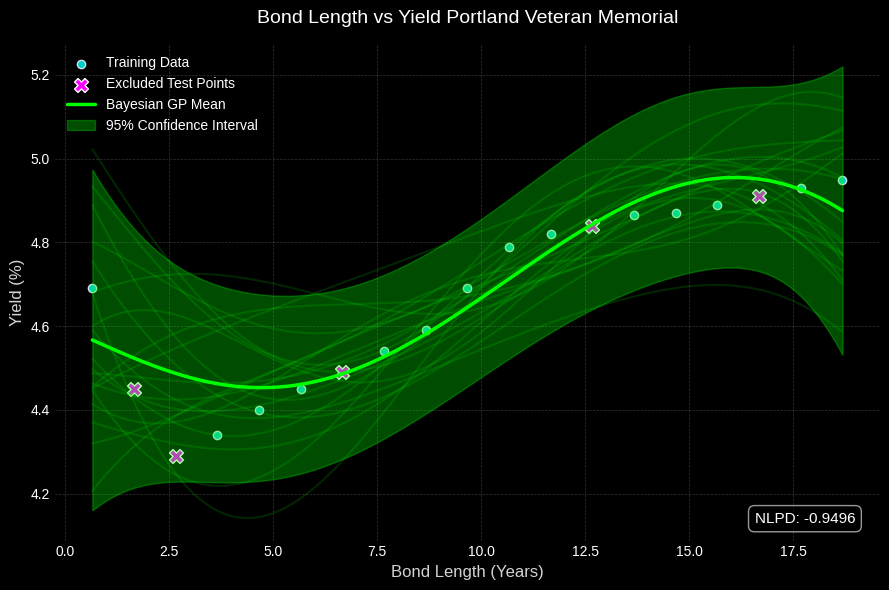

/usr/local/lib/python3.12/dist-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Learned kernel: 2.64**2 * RBF(length_scale=10)


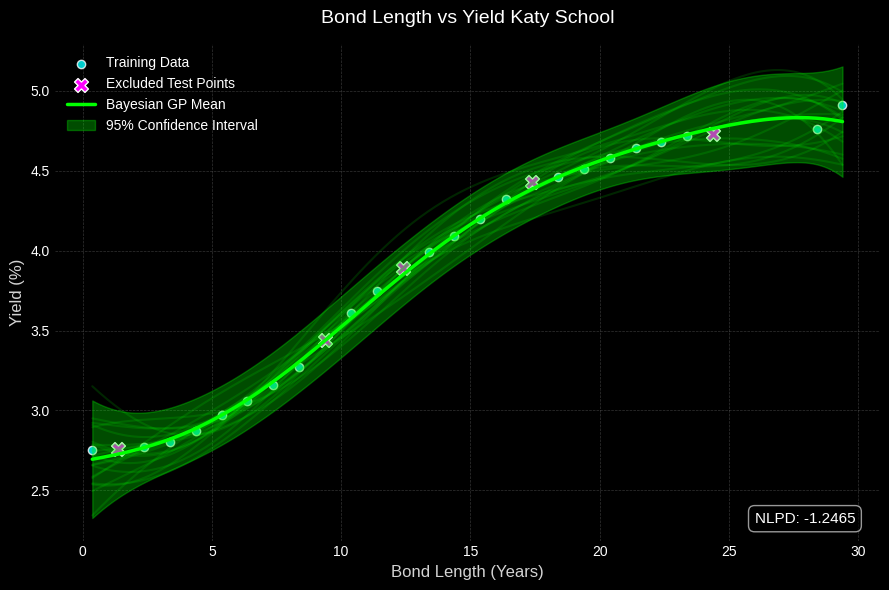

In [ ]:
# Function performs a Bayesian Gaussian Process regression on the given data
# Selects 5 points for test set to evaluate performance while preventing extrapolation
# Computes Negative Log Predictive Density (NLPD)

def run_bayesian_gp(df, title_text, test_size=5, random_seed=42, n_samples=20):

    # Select test indices excluding first and last index (no edges)
    np.random.seed(random_seed)
    eligible_indices = df.index[1:-1]
    exclude_indices = np.random.choice(eligible_indices, size=test_size, replace=False)

    # Train/test split
    df_train = df.drop(index=exclude_indices)
    df_test = df.loc[exclude_indices]

    x_train = df_train['Bond Length (Years)'].values.reshape(-1, 1)
    y_train = df_train['Yield'].values

    x_test = df_test['Bond Length (Years)'].values.reshape(-1, 1)
    y_test = df_test['Yield'].values

    # Define kernel and GP
    kernel = C(1.0, (1e-3, 1e3)) * RBF(length_scale=0.5, length_scale_bounds=(1e-3, 10))
    gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=15, alpha=0.05)

    # Fit model
    gpr.fit(x_train, y_train)
    print("Learned kernel:", gpr.kernel_)

    # Predict on dense grid
    x_pred = np.linspace(x_train.min(), x_train.max(), 200).reshape(-1, 1)
    y_pred, sigma = gpr.predict(x_pred, return_std=True)

    # Sample posterior functions
    samples = gpr.sample_y(x_pred, n_samples=n_samples, random_state=random_seed)

    # Predict test points & compute NLPD
    y_pred_test, sigma_test = gpr.predict(x_test, return_std=True)
    nlpd = -np.mean(norm.logpdf(y_test, loc=y_pred_test, scale=sigma_test))

    # Plot
    plt.style.use('dark_background')
    plt.figure(figsize=(9, 6))
    plt.scatter(x_train, y_train, color='cyan', edgecolors='white', label='Training Data', alpha=0.8)
    plt.scatter(x_test, y_test, color='magenta', edgecolors='white', label='Excluded Test Points', s=100, marker='X')

    for i in range(n_samples):
        plt.plot(x_pred, samples[:, i], color='lime', alpha=0.15)

    plt.plot(x_pred, y_pred, color='lime', linewidth=2.5, label='Bayesian GP Mean')
    plt.fill_between(x_pred.flatten(), y_pred - 2*sigma, y_pred + 2*sigma, color='lime', alpha=0.3, label='95% Confidence Interval')

    plt.title(title_text, fontsize=14, color='white', pad=15)
    plt.xlabel('Bond Length (Years)', fontsize=12, color='lightgray')
    plt.ylabel('Yield (%)', fontsize=12, color='lightgray')
    plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.4)
    plt.legend()

    # Show NLPD
    plt.text(0.97, 0.03, f"NLPD: {nlpd:.4f}", fontsize=11, color='white',
             transform=plt.gca().transAxes, ha='right', va='bottom',
             bbox=dict(facecolor='black', alpha=0.6, boxstyle='round,pad=0.4'))

    plt.tight_layout()
    plt.show()

    return gpr

# Run on data
gpr_model_austin = run_bayesian_gp(df_austin, 'Bond Length vs Yield Austin School')
gpr_model_portland = run_bayesian_gp(df_portland, 'Bond Length vs Yield Portland Affordable Housing')
gpr_model_portland_veteran = run_bayesian_gp(df_portland_veteran, 'Bond Length vs Yield Portland Veteran Memorial')
gpr_model_katy = run_bayesian_gp(df_katy, 'Bond Length vs Yield Katy School')



/usr/local/lib/python3.12/dist-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


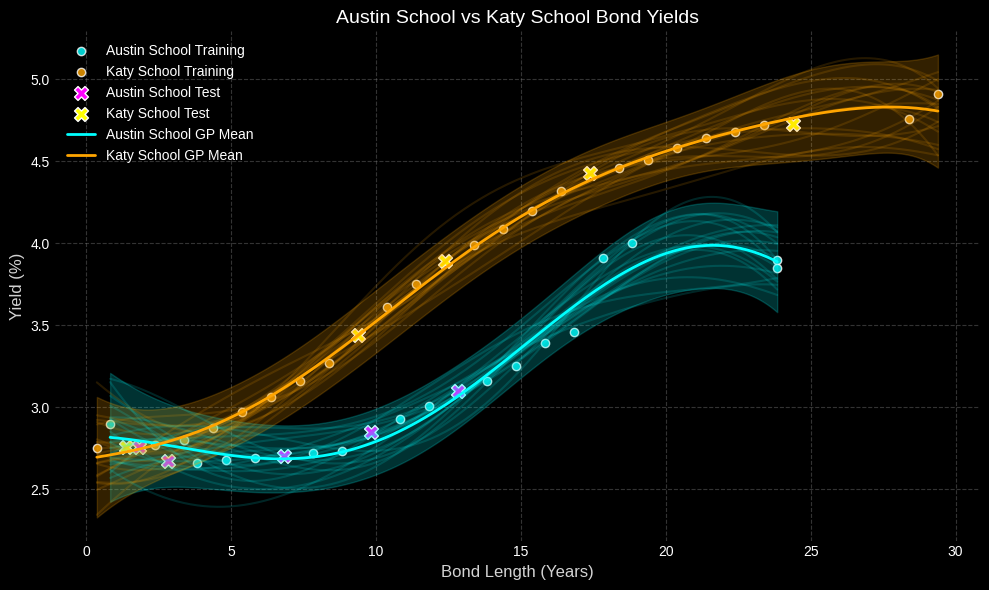

/usr/local/lib/python3.12/dist-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


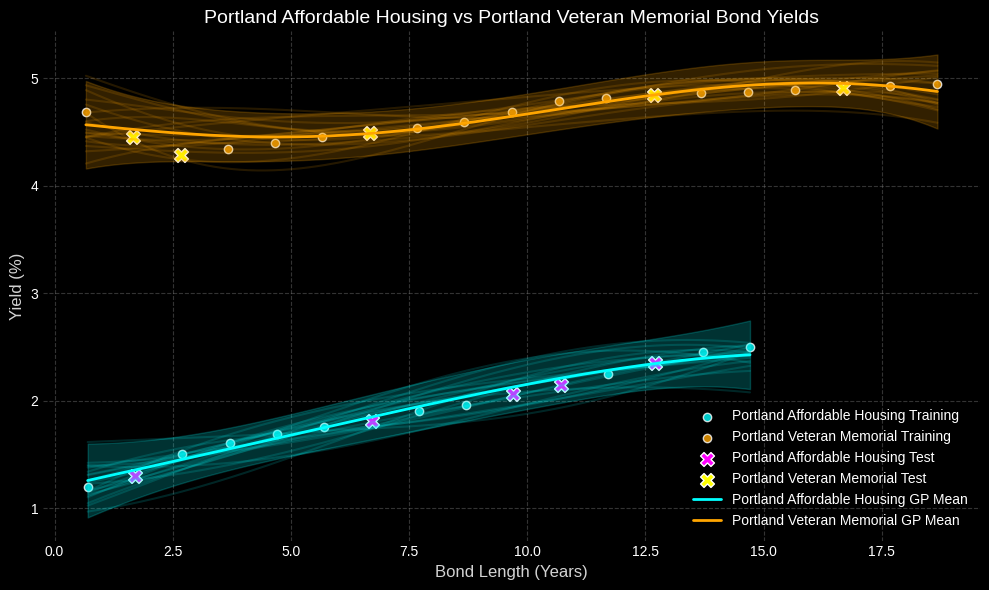

In [ ]:
# Function to fit the Bayesian model on two datasets and plot on one graph for comparison

def plot_combined_bayesian_gp(df1, df2, label1, label2, test_size=5, random_seed=42, n_samples=20):

    # Helper to fit GP and return train/test/prediction
    def fit_gp(df):
        np.random.seed(random_seed)
        eligible_indices = df.index[1:-1]
        exclude_indices = np.random.choice(eligible_indices, size=test_size, replace=False)
        df_train = df.drop(index=exclude_indices)
        df_test = df.loc[exclude_indices]

        x_train = df_train['Bond Length (Years)'].values.reshape(-1, 1)
        y_train = df_train['Yield'].values

        x_test = df_test['Bond Length (Years)'].values.reshape(-1, 1)
        y_test = df_test['Yield'].values

        kernel = C(1.0, (1e-3, 1e3)) * RBF(length_scale=0.5, length_scale_bounds=(1e-3, 10))
        gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=15, alpha=0.05)
        gpr.fit(x_train, y_train)

        x_pred = np.linspace(min(x_train.min(), x_test.min()), max(x_train.max(), x_test.max()), 200).reshape(-1, 1)
        y_pred, sigma = gpr.predict(x_pred, return_std=True)
        samples = gpr.sample_y(x_pred, n_samples=n_samples, random_state=random_seed)

        return x_train, y_train, x_test, y_test, x_pred, y_pred, sigma, samples

    # Fit both datasets
    x1_train, y1_train, x1_test, y1_test, x1_pred, y1_pred, sigma1, samples1 = fit_gp(df1)
    x2_train, y2_train, x2_test, y2_test, x2_pred, y2_pred, sigma2, samples2 = fit_gp(df2)

    # Plot combined
    plt.style.use('dark_background')
    plt.figure(figsize=(10,6))

    # Plot sample lines (possible outcomes)
    for i in range(n_samples):
        plt.plot(x1_pred, samples1[:, i], color='cyan', alpha=0.15)
        plt.plot(x2_pred, samples2[:, i], color='orange', alpha=0.15)

    # Plot training data
    plt.scatter(x1_train, y1_train, color='cyan', edgecolors='white', label=f'{label1} Training', alpha=0.8)
    plt.scatter(x2_train, y2_train, color='orange', edgecolors='white', label=f'{label2} Training', alpha=0.8)

    # Plot test points
    plt.scatter(x1_test, y1_test, color='magenta', edgecolors='white', label=f'{label1} Test', s=100, marker='X')
    plt.scatter(x2_test, y2_test, color='yellow', edgecolors='white', label=f'{label2} Test', s=100, marker='X')

    # Plot GP mean and confidence
    plt.plot(x1_pred, y1_pred, color='cyan', linewidth=2, label=f'{label1} GP Mean')
    plt.fill_between(x1_pred.flatten(), y1_pred - 2*sigma1, y1_pred + 2*sigma1, color='cyan', alpha=0.2)

    plt.plot(x2_pred, y2_pred, color='orange', linewidth=2, label=f'{label2} GP Mean')
    plt.fill_between(x2_pred.flatten(), y2_pred - 2*sigma2, y2_pred + 2*sigma2, color='orange', alpha=0.2)

    plt.xlabel('Bond Length (Years)', fontsize=12, color='lightgray')
    plt.ylabel('Yield (%)', fontsize=12, color='lightgray')
    plt.title(f'{label1} vs {label2} Bond Yields', fontsize=14, color='white')
    plt.grid(color='gray', linestyle='--', alpha=0.4)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Plotting Austin & Katy, Portland Affordable Housing & Portland Veteran Memorial
plot_combined_bayesian_gp(df_austin, df_katy, label1='Austin School', label2='Katy School')
plot_combined_bayesian_gp(df_portland, df_portland_veteran, label1='Portland Affordable Housing', label2='Portland Veteran Memorial')


<Figure size 1000x500 with 0 Axes>

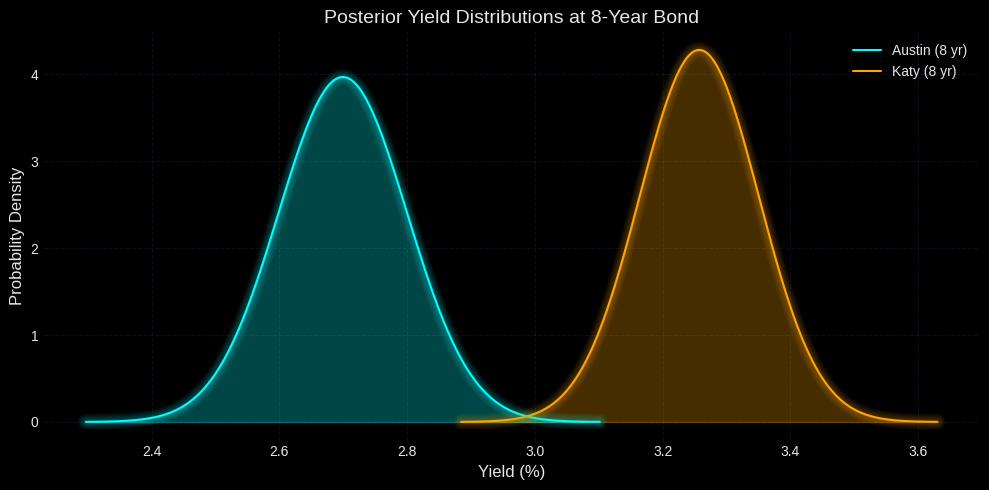

In [ ]:
# Plots posterior distributions at certain bond lengths from different models
# Allows for comparison of uncertainty across sector or city

def plot_posterior_distributions(gpr1, gpr2, bond_length=5, label1='Austin', label2='Katy', style='cyberpunk'):

    # Predict mean and std at the selected bond length
    x_point = np.array([[bond_length]])
    mu1, std1 = gpr1.predict(x_point, return_std=True)
    mu2, std2 = gpr2.predict(x_point, return_std=True)

    plt.style.use(style)
    plt.figure(figsize=(10,5))
    fig, ax = plt.subplots(figsize=(10,5))
    fig.patch.set_facecolor('black')
    ax.set_facecolor('black')

    colors = ['cyan', 'orange']
    labels = [label1, label2]
    mus = [mu1[0], mu2[0]]
    stds = [std1[0], std2[0]]

    for color, mu, std, lbl in zip(colors, mus, stds, labels):
        x_vals = np.linspace(mu - 4*std, mu + 4*std, 300)
        y_vals = norm.pdf(x_vals, mu, std)
        plt.plot(x_vals, y_vals, color=color, label=f'{lbl} ({bond_length} yr)')
        plt.fill_between(x_vals, y_vals, color=color, alpha=0.2)

    plt.title(f"Posterior Yield Distributions at {bond_length}-Year Bond", fontsize=14)
    plt.xlabel("Yield (%)", fontsize=12)
    plt.ylabel("Probability Density", fontsize=12)
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.3)
    mplcyberpunk.add_glow_effects()
    plt.tight_layout()
    plt.show()


# Plotting for katy school bond data
plot_posterior_distributions(gpr_model_austin, gpr_model_katy, bond_length=8, label1='Austin', label2='Katy')
